# Installing Packages


In [31]:
# import Pkg; Pkg.add("Distributions")
using Plots, Statistics, FinancialToolbox, Dates, Distributions
using DelimitedFiles,Random, DiffEqBase.EnsembleAnalysis, Flux, Optimization, OptimizationFlux, DiffEqFlux, StochasticDiffEq, SciMLBase.EnsembleAnalysis
Random.seed!(1)

TaskLocalRNG()

# Generating Constant Elasticity of Variance Stock Paths
$dS_t = rS_tdt + \sigma S_t^\alpha dW_t$ <br>
$S_0 = 100$ <br>
$r = 8\%$ <br>
$\sigma = 200\%$ <br>
$\alpha \in [0,1]$, So the stock model produces behaviour consistent with the leverage effect.  <br>
$\alpha = 0.5$, a square root process - similar to CIR without mean reversion, has an analytical solution for stock prices. <br>

In [32]:
S₀ = Float32[100.]  # Initial value of the SDE.
r = 0.08 # Risk-free rate of interest.
σ = 2 # Volatility. 
α = 0.5
datasize = 30 # The size of the solution/stock paths we want to calculate. 
tspan = (0.0f0, 1.0f0) # The time horizon we wish to obtain the stock path over. 
tsteps = range(tspan[1], tspan[2], length = datasize) # Each time step we want a stock price. 


function CEV_Drift(du, S, p, t) # Drift function of GBM. 
    du .= r*S
end


function CEV_Diffusion(du, S, p, t) # Diffusion function of GBM. 
    du .= σ*S.^α
end

CEV = SDEProblem(CEV_Drift, CEV_Diffusion, S₀, tspan) # Specifying the GBM. 

SDEProblem with uType Vector{Float32} and tType Float32. In-place: true
timespan: (0.0f0, 1.0f0)
u0: 1-element Vector{Float32}:
 100.0

# Training Data
We generate training data from the CEV model. We do this by using DifferentialEquations.jl's parallel ensemble interface to generate data from the average of 1,000,000 runs of the SDE, and calculate means and variances across the 1,000,000 runs, at each time step. 

In [33]:
# Don't need the simulation as GBM has a closed form. 
CEV_Means = S₀.*exp.(r.*tsteps)

CEV_Vars = (S₀*σ.^(2))/r.*(exp.(2*r.*tsteps).- exp.(r.*tsteps))

CEV_Means = hcat(Float32.(CEV_Means))'

CEV_Vars = hcat(Float32.(CEV_Vars))'


1×30 adjoint(::Matrix{Float32}) with eltype Float32:
 0.0  13.8503  27.8155  41.8963  …  399.441  416.531  433.757  451.119

# Neural SDE
We specify our neural SDE to apprximate the CEV. We then show how it compares to the CEV before any training.

In [294]:
# Pre training the drift coefficient, no-arbitrage condition
gridsize = 1000;
Func(x) = r*x;
X_Training = collect(range(0,stop=10,length=gridsize));
Y_Training = Func.(X_Training);

X_Testing = collect(range(0.01,stop=5,length=gridsize));
Y_Testing = Func.(X_Testing)

data = []
for i in 1:length(X_Training)
    push!(data, ([X_Training[i]], Y_Training[i]))
end

Pre_NSDE_Drift = Flux.Chain(Flux.Dense(1,1))
plt1 = plot(X_Testing ,[Y_Testing  Pre_NSDE_Drift(X_Testing')'],title="Diffusion Coefficient Before Training",label=["CEV Diffusion Coefficient" "Neural Network"], xlabel = "S",ylabel = "Diffusion Coefficient") # before training

loss_drift(x, y) = Flux.mse(Pre_NSDE_Drift(x), y)
opt_drift = Descent(0.01)
ps = Flux.params(Pre_NSDE_Drift)

for epoch in 1:500 
    Flux.train!(loss_drift, ps, data, opt_drift);
end

plt3 = plot(X_Testing ,[Y_Testing Pre_NSDE_Drift(X_Testing')'],title="Drift Coefficient After Training",label=["CEV Drift Coefficient" "Neural Network"], xlabel = "S",ylabel = "Drift Coefficient"); # before training


In [164]:
p1, re1 = Flux.destructure(Pre_NSDE_Drift)
Q = 16; 
Pre_NSDE_Diffusion = Flux.Chain(Flux.Dense(1,Q,elu),Flux.Dense(Q,Q,elu),Flux.Dense(Q,Q,elu),Flux.Dense(Q,1,softplus));  
p2, re2 = Flux.destructure(Pre_NSDE_Diffusion)

Pre_NSDE = NeuralDSDE(Pre_NSDE_Drift , Pre_NSDE_Diffusion, tspan, SOSRI(), saveat = tsteps, reltol = 1e-1, abstol = 1e-1) # Specifying the neural SDE.

NeuralDSDE()

In [295]:
# Get the prediction using the correct initial condition
prediction0 = Pre_NSDE(S₀) # Get a prediction using our untrained neural SDE, but with the correct initial condition.

#NSDE_Drift(s, p, t) = re1(p[1:Pre_NSDE.len])(s)
NSDE_Drift(u, p, t) = re1(p[1:Pre_NSDE.len])(u)
NSDE_Diffusion(u, p, t) = re2(p[Pre_NSDE.len+1:end])(u) # i.e. NSDE.len = 151, and there are 153 parameters, so we need to take the last two. 

NSDE = SDEProblem(NSDE_Drift, NSDE_Diffusion, S₀,(0.0f0, 1.0f0), Pre_NSDE.p) # Form the neural SDE into an SDE so it can be solved. Taking the parameters from the neural SDE. 

NSDE_ensemble_nprob = EnsembleProblem(NSDE)
NSDE_ensemble_nsol = solve(NSDE_ensemble_nprob, SOSRI(), trajectories = 10000, saveat = tsteps) # Simulating many paths. 
NSDE_ensemble_nsum = EnsembleSummary(NSDE_ensemble_nsol) # Taking means and varaince of the simulated paths. 

plt1 = plot(NSDE_ensemble_nsum, title = "Neural SDE: Before Training") # Plotting the neural SDE means and variances before training. 
scatter!(plt1, tsteps, CEV_Means',yerror = CEV_Vars', xlabel = "Time" , ylabel = "Share Price") # Plotting the GBM means.  

scatter(tsteps, prediction0[1,:], label = "Prediction")
scatter!(tsteps, CEV_Means', label = "Data",title = "Neural SDE Prediction Before Training", xlabel = "Time" , ylabel = "Share Price");


In [247]:
m_before,v_before = timeseries_steps_meanvar(NSDE_ensemble_nsol)
m_before = m_before[:,:]
v_before = v_before[:,:]

1×30 Matrix{Float32}:
 0.0  6.11152  12.0749  18.4988  …  184.939  191.953  201.504  209.889

# Loss Function 
We define a loss function that calculates the mean and variance from n runs at each time point and uses the distance from the data values. It compares the CEV means and variances, to the neural SDE means and variances. This is training via moments matching.

In [166]:
function predict_neuralsde(p, u = S₀) 
  return Array(Pre_NSDE(u, p)) # Returns an array of stock prices/SDE solutions at each time point. 
end

function loss_neuralsde(p; n = 100)
  u = repeat(reshape(S₀, :, 1), 1, n) # Makes a 1 x n(100) matrix.
  samples = predict_neuralsde(p, u) # Takes n many random paths from the neural SDE, with the weights p. 
  means = mean(samples, dims = 2) # Takes the mean at each time point. 
  vars = var(samples, dims = 2, mean = means)[:, 1, :] # Computes the sample variance with known means at each time point. 
  means = means[:, 1, :] # Puts the means into a single vector. 
  loss = sum(abs2, CEV_Means - means) + sum(abs2, CEV_Vars - vars) # Our loss is the abs sum of the difference of means and variances. 
    return loss , means, vars
end

loss_neuralsde (generic function with 1 method)

In [167]:
list_plots = []
iter = 0
loss1 = zeros(1,10000)
# Callback function to observe training
callback = function (p, loss, means, vars; doplot = false)
  global list_plots, iter

  if iter == 0
    list_plots = []
  end
  iter += 1

  # loss against current data
  display(loss)
    display(iter)
  loss1[iter] = loss
  # plot current prediction against data
  plt = Plots.scatter(tsteps, CEV_Means[1,:], yerror = CEV_Vars[1,:],
                     ylim = (-4.0, 8.0), label = "data")
  Plots.scatter!(plt, tsteps, means[1,:], ribbon = vars[1,:], label = "prediction")
  push!(list_plots, plt)

  if doplot
    display(plt)
  end
  return false
end

#92 (generic function with 1 method)

In [168]:
t1 = now()

opt = ADAM()

# First round of training with n = 10000
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=10000), adtype)
optprob = Optimization.OptimizationProblem(optf, Pre_NSDE.p)
result1 = Optimization.solve(optprob, opt, callback = callback, maxiters = 200)  # 200 iterations of training. 


575580.94f0

1

422513.34f0

2

302136.1f0

3

217700.94f0

4

127522.2f0

5

56484.39f0

6

14277.0205f0

7

874.503f0

8

16872.746f0

9

29845.918f0

10

44071.105f0

11

79798.86f0

12

73374.29f0

13

77529.48f0

14

79760.33f0

15

42847.08f0

16

18347.033f0

17

10448.8125f0

18

2426.1243f0

19

855.98413f0

20

1808.6837f0

21

4572.402f0

22

11812.18f0

23

8549.113f0

24

17799.12f0

25

21536.455f0

26

17245.152f0

27

21375.379f0

28

19253.018f0

29

14839.632f0

30

5365.5654f0

31

6052.353f0

32

5237.699f0

33

1005.50824f0

34

1322.3893f0

35

1467.5437f0

36

5643.436f0

37

2357.4976f0

38

9468.429f0

39

7263.5737f0

40

9146.439f0

41

3963.1304f0

42

1873.1237f0

43

3520.2593f0

44

1131.6569f0

45

1397.4331f0

46

861.9409f0

47

999.9836f0

48

759.2605f0

49

1099.0098f0

50

4365.872f0

51

2533.6892f0

52

2683.1565f0

53

1488.5162f0

54

1254.0326f0

55

2700.965f0

56

3129.7825f0

57

1298.8123f0

58

1174.9401f0

59

836.5001f0

60

638.9547f0

61

1867.8389f0

62

1612.6437f0

63

6094.288f0

64

2583.9539f0

65

647.3974f0

66

1689.0493f0

67

433.23578f0

68

3774.1975f0

69

560.01935f0

70

826.37317f0

71

487.2049f0

72

1385.8005f0

73

1518.098f0

74

1223.9482f0

75

1145.3955f0

76

1152.0852f0

77

452.95828f0

78

1611.309f0

79

3979.113f0

80

1080.084f0

81

613.3392f0

82

2073.171f0

83

439.40488f0

84

804.0836f0

85

3087.2964f0

86

1043.6301f0

87

1716.2346f0

88

816.92303f0

89

1082.5071f0

90

1205.3402f0

91

621.8914f0

92

2235.3083f0

93

2106.651f0

94

746.23376f0

95

1759.9027f0

96

1458.71f0

97

267.65863f0

98

879.06274f0

99

1304.849f0

100

1387.2932f0

101

1564.3965f0

102

742.2468f0

103

682.68225f0

104

2163.531f0

105

2076.542f0

106

1281.8844f0

107

530.08624f0

108

918.07855f0

109

1790.0903f0

110

1988.0201f0

111

841.0747f0

112

1300.4274f0

113

1220.3945f0

114

1403.1428f0

115

545.3184f0

116

790.0327f0

117

2071.2417f0

118

4247.0005f0

119

1166.4437f0

120

462.1516f0

121

614.4091f0

122

2645.8352f0

123

578.4336f0

124

1055.3728f0

125

1216.3212f0

126

2088.82f0

127

1572.2238f0

128

3460.9463f0

129

2443.078f0

130

2263.5972f0

131

3452.9805f0

132

881.4446f0

133

1113.2664f0

134

1094.4978f0

135

1037.122f0

136

527.2858f0

137

642.1527f0

138

687.67017f0

139

1910.7899f0

140

1718.1741f0

141

513.8117f0

142

521.8103f0

143

879.22754f0

144

635.3123f0

145

1712.3229f0

146

756.7081f0

147

394.44977f0

148

355.78738f0

149

827.66345f0

150

2093.9602f0

151

1089.9597f0

152

1085.267f0

153

785.63367f0

154

2779.518f0

155

894.3073f0

156

1097.6107f0

157

1492.0743f0

158

806.1587f0

159

3184.39f0

160

450.67545f0

161

1022.1521f0

162

1266.9443f0

163

1250.6685f0

164

1915.9313f0

165

611.5496f0

166

1262.1864f0

167

1450.4427f0

168

971.0467f0

169

2878.5718f0

170

1152.44f0

171

1315.5271f0

172

2397.3157f0

173

1139.4054f0

174

6341.005f0

175

1882.4357f0

176

1758.4569f0

177

5279.22f0

178

3666.578f0

179

3835.9575f0

180

4559.5513f0

181

1020.03253f0

182

933.387f0

183

792.7842f0

184

1238.2799f0

185

609.81866f0

186

654.0872f0

187

3183.005f0

188

1014.059f0

189

809.8852f0

190

2253.215f0

191

634.6517f0

192

732.3056f0

193

659.4346f0

194

553.56494f0

195

797.6277f0

196

569.0898f0

197

2754.3042f0

198

544.53424f0

199

639.1931f0

200

267.65863f0

201

u: 595-element Vector{Float32}:
  0.08186012
  0.0018193398
  0.2202951
  0.30428252
 -0.22157581
  0.014723897
 -0.111638874
 -0.25864965
 -0.23326235
 -0.22280084
 -0.2284022
 -0.0072173323
 -0.25467393
  ⋮
  0.35671127
 -0.25998816
  0.5290378
 -0.3244193
  0.45365337
  0.56385785
  0.5532183
  0.33811337
 -0.08550504
  0.14910343
 -0.26475438
  0.007415026

In [169]:
t2 = now()
println(t2-t1)

658816 milliseconds


In [170]:
t3 = now()

optf2 = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=50000), adtype)
optprob2 = Optimization.OptimizationProblem(optf2, result1.u)
result2 = Optimization.solve(optprob2, opt, callback = callback, maxiters = 300)
display(result2)

1145.5374f0

202

18631.195f0

203

952.64935f0

204

5480.4517f0

205

9919.166f0

206

7286.001f0

207

3779.5269f0

208

1738.2047f0

209

2152.4253f0

210

6730.6787f0

211

4126.703f0

212

3383.6016f0

213

2086.7288f0

214

1131.04f0

215

2241.418f0

216

2221.6948f0

217

2567.9485f0

218

2006.6554f0

219

830.20337f0

220

703.0951f0

221

3297.9658f0

222

1481.1251f0

223

3272.5515f0

224

2596.0935f0

225

786.22955f0

226

574.8251f0

227

1429.6598f0

228

1860.9694f0

229

1751.2728f0

230

1199.1221f0

231

1154.2737f0

232

515.3249f0

233

906.95245f0

234

1219.5692f0

235

3043.735f0

236

1479.3612f0

237

1133.9368f0

238

1245.1611f0

239

588.97626f0

240

1088.3849f0

241

1300.6161f0

242

1028.9612f0

243

859.25476f0

244

704.91833f0

245

619.20355f0

246

2229.2822f0

247

658.55066f0

248

3590.8367f0

249

355.3421f0

250

409.26904f0

251

457.3256f0

252

504.9782f0

253

958.22345f0

254

1040.4019f0

255

515.99774f0

256

610.3166f0

257

688.52454f0

258

709.4564f0

259

1061.3062f0

260

1260.5985f0

261

875.98096f0

262

547.6338f0

263

462.35687f0

264

949.10815f0

265

826.20386f0

266

508.1046f0

267

1088.4247f0

268

501.98013f0

269

476.99277f0

270

406.78793f0

271

486.51184f0

272

491.14227f0

273

416.36136f0

274

654.3808f0

275

1217.1815f0

276

582.79193f0

277

624.045f0

278

809.3113f0

279

816.20306f0

280

799.11707f0

281

599.6074f0

282

1533.9927f0

283

523.8329f0

284

690.35645f0

285

861.82715f0

286

471.80643f0

287

431.58777f0

288

629.3814f0

289

898.5722f0

290

667.8572f0

291

805.18176f0

292

461.98544f0

293

526.6135f0

294

1363.5835f0

295

1090.5813f0

296

354.31586f0

297

301.81418f0

298

336.01346f0

299

279.3865f0

300

265.9661f0

301

391.58353f0

302

362.5144f0

303

450.64767f0

304

294.21072f0

305

428.81018f0

306

479.62427f0

307

440.3411f0

308

856.93585f0

309

291.20453f0

310

358.26184f0

311

378.46075f0

312

390.01086f0

313

460.90125f0

314

975.14966f0

315

714.78986f0

316

512.06f0

317

469.88483f0

318

356.3844f0

319

419.86304f0

320

859.0248f0

321

499.27408f0

322

433.87195f0

323

372.34906f0

324

358.24545f0

325

734.1202f0

326

738.22394f0

327

752.6821f0

328

509.23483f0

329

442.33084f0

330

787.0048f0

331

750.7896f0

332

483.77887f0

333

359.58212f0

334

381.67325f0

335

1129.2834f0

336

557.74365f0

337

684.5472f0

338

458.50464f0

339

459.44864f0

340

591.62976f0

341

568.2792f0

342

596.1389f0

343

460.7611f0

344

444.50354f0

345

476.99567f0

346

489.8163f0

347

586.91595f0

348

508.16293f0

349

420.93063f0

350

386.6658f0

351

343.8056f0

352

447.13297f0

353

575.2629f0

354

599.7227f0

355

612.6104f0

356

737.69226f0

357

354.4571f0

358

1283.2565f0

359

839.19354f0

360

1163.0139f0

361

845.9218f0

362

381.83133f0

363

1064.3994f0

364

619.22375f0

365

775.42053f0

366

583.75775f0

367

518.8794f0

368

1189.5653f0

369

595.8467f0

370

373.01202f0

371

531.42365f0

372

783.772f0

373

758.59625f0

374

359.96817f0

375

627.80786f0

376

489.04523f0

377

1033.1473f0

378

833.6872f0

379

1229.3793f0

380

594.4192f0

381

505.5716f0

382

474.18503f0

383

501.20312f0

384

699.82556f0

385

501.9414f0

386

441.8158f0

387

431.75327f0

388

649.7771f0

389

500.5733f0

390

373.39014f0

391

313.3588f0

392

752.3988f0

393

685.1064f0

394

523.9068f0

395

460.07632f0

396

382.91632f0

397

401.05225f0

398

558.75146f0

399

619.3758f0

400

778.6516f0

401

435.01953f0

402

429.89093f0

403

850.22064f0

404

911.4791f0

405

987.75745f0

406

541.958f0

407

644.6886f0

408

425.1415f0

409

416.3415f0

410

560.5278f0

411

330.59457f0

412

525.5088f0

413

1539.9442f0

414

801.19434f0

415

471.61014f0

416

1472.9263f0

417

1176.9152f0

418

1326.0773f0

419

821.92847f0

420

415.16876f0

421

3268.5413f0

422

3449.1455f0

423

955.67535f0

424

601.6009f0

425

390.19244f0

426

503.72052f0

427

942.462f0

428

258.10034f0

429

506.2308f0

430

525.5285f0

431

776.91705f0

432

451.43118f0

433

407.23816f0

434

603.1898f0

435

248.4934f0

436

403.31833f0

437

314.25952f0

438

712.0788f0

439

349.64993f0

440

338.18597f0

441

327.99652f0

442

350.44366f0

443

328.89893f0

444

693.9429f0

445

351.7297f0

446

354.05475f0

447

674.1007f0

448

415.617f0

449

342.37103f0

450

884.74994f0

451

332.19412f0

452

653.0763f0

453

689.1875f0

454

2731.8506f0

455

565.87915f0

456

473.3503f0

457

603.74255f0

458

1419.6399f0

459

666.6885f0

460

351.05945f0

461

477.46503f0

462

622.289f0

463

581.25f0

464

396.597f0

465

880.4721f0

466

1385.3096f0

467

1668.8613f0

468

437.5755f0

469

356.37015f0

470

1200.6042f0

471

1498.2367f0

472

849.75586f0

473

377.5808f0

474

817.62366f0

475

1322.4934f0

476

633.8427f0

477

481.66852f0

478

519.86304f0

479

441.44537f0

480

964.0428f0

481

462.0444f0

482

889.1092f0

483

385.5386f0

484

367.81808f0

485

586.0321f0

486

693.78326f0

487

347.6808f0

488

331.70825f0

489

830.4254f0

490

649.77686f0

491

581.2867f0

492

351.33484f0

493

611.97485f0

494

420.00647f0

495

874.0557f0

496

523.28656f0

497

529.60876f0

498

347.41003f0

499

403.05487f0

500

466.41083f0

501

248.4934f0

502

u: 595-element Vector{Float32}:
  0.058811042
 -0.01751039
  0.21887179
  0.30433312
 -0.24453083
  0.01318986
 -0.10850753
 -0.17368248
 -0.2569517
 -0.15448971
 -0.2506005
 -0.0068095503
 -0.25007978
  ⋮
  0.35667428
 -0.26165083
  0.5289701
 -0.32608196
  0.45165294
  0.56219584
  0.5515563
  0.33738574
 -0.087167576
  0.14743182
 -0.26636258
  0.009077495

In [171]:
# Time taken to execute pre-training
t4 = now()
println(t4-t3)

9533132 milliseconds


In [296]:
loss, means, vars = loss_neuralsde(result1.u, n = 100000)

plt2 = Plots.scatter(tsteps, CEV_Means', yerror = CEV_Vars',
                     label = "Data", title = "Neural SDE: After Training",
                     xlabel = "Time")
plot!(plt2, tsteps, means', lw = 3, ribbon = vars', label = "Prediction")
display(loss)
plt = plot(plt1, plt2, layout = (2 , 1));


556.9483f0

# Option Pricing
Pricing vanilla call options with the trained neural SDE, and comparing it to the CEV call prices for various strikes.

In [173]:
# Vanilla Call Price Function. 

function call_pricer(stock_price,K)
    A = stock_price-ones(size(stock_price))*K
    B = maximum([A zeros(size(A))],dims=2)
    Call_Price = exp(-r*tspan[2])*mean(B)
    return Call_Price
end 

call_pricer (generic function with 1 method)

In [231]:
# Generating 100,000 neural SDE stock paths.
prob = result1.u
u1 = repeat(reshape(S₀, :, 1), 1, 100000)
a = predict_neuralsde(prob, u1)[1,:,:]
stock_price_NSDE = a[:,end];

In [201]:
K = range(80, 120, length = 21)
function C(S0, r, σ, T, K, α)
k = 2*r./(σ.^2 * (1 - α) * (exp(2*r * (1 - α) * T) - 1))
x = k * S0.^(2 * (1 - α)) * exp(2*r * (1 - α) * T)
x = x[1]
y = k * K.^(2 * (1 - α))
z = 2 + 1 / (1 - α)
non_central_chi_square = NoncentralChisq(z, x)
X_x = cdf(non_central_chi_square, y)
X_y = cdf(NoncentralChisq(z - 2, y), x)
return S0 * (1 .- X_x) .- K * exp(-r * T) * X_y
end



CEV_Price = zeros(1,length(K)) 

for i in 1:length(K)
    A = C(S₀, r, σ, tspan[2], K[i], α)
    CEV_Price[i] = A[1]
end

CEV_Price

1×21 Matrix{Float64}:
 26.766  25.0902  23.4498  21.8491  …  5.57006  4.90483  4.30122  3.75628

In [297]:
NSDE_Price = zeros(1,length(K))

for i in 1:length(K)
    NSDE_Price[i] = call_pricer(stock_price_NSDE,K[i]) 
end 


plot(K,CEV_Price',label = "CEV Analytical Call Price")
plt5 = plot!(K,NSDE_Price',title="Call Prices After Training",label = "Neural SDE Call Price After Training",xlabel = "Strike",ylabel = "Price");

In [298]:
CEV_Vol = zeros(1,length(K))
Vol_After = zeros(1,length(K))

for i in 1:length(K)
    CEV_Vol[i] = blsimpv(100,K[i],r,tspan[2],CEV_Price[i])
    Vol_After[i] = blsimpv(100,K[i],r,tspan[2],NSDE_Price[i])
end 
plt19 = scatter(K,Vol_After',title="Call Prices",label = "Neural SDE Implied Volatility After Training",xlabel = "Strike",ylabel = "Implied Volatility");
scatter(plt19)
plt11 = plot!(K,CEV_Vol', linewidth=2,c=:red,title="Implied Volatility",label = "CEV Implied Volatility");

# Plotting

In [238]:
using Gadfly, Fontconfig, Cairo, DataFrames, Compose;

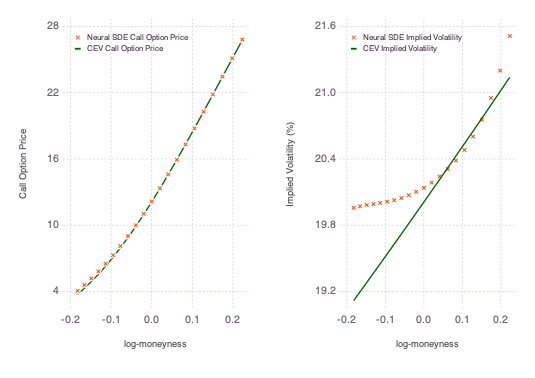

In [292]:
# Plotting call prices
K1 = 100 ./ range(80, 120, length = 21)
K1 = K1[:,1]
log_moneyness = log.(K1)

NSDE_Call_Prices = NSDE_Price[1,:];
CEV_Call_Prices = CEV_Price[1,:];
NSDE_Call_Vol = Vol_After[1,:].*100;
CEV_Call_Vol = CEV_Vol[1,:].*100;

layer7 = layer(x= log_moneyness, y=NSDE_Call_Prices,Geom.point,shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=CEV_Call_Prices,Geom.line,Theme(line_width = 1pt,default_color=colorant"#006400"))
p5 = Gadfly.plot(layer7,layer8,Guide.yticks(ticks = [ 4    10    16    22    28]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Call Option Price"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Call Option Price","CEV Call Option Price"],["#FF6347","#006400"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=3, ymax=28))


layer9 = layer(x=log_moneyness, y= NSDE_Call_Vol,Geom.point, shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=CEV_Call_Vol, Geom.line,Theme(line_width = 1pt,default_color=colorant"#006400"))
p6 = Gadfly.plot(layer8,layer9,Guide.yticks(ticks = [19.20   19.80   20.40 21.00   21.60]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Implied Volatility (%)"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Implied Volatility","CEV Implied Volatility"],["#FF6347","#006400"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=19.1, ymax=21.6))#draw(PDF("myplot20.pdf", 14cm, 7cm), plt)
plt = hstack(p5,p6)
#draw(PDF("myplot1.pdf", 14cm, 7cm), plt)

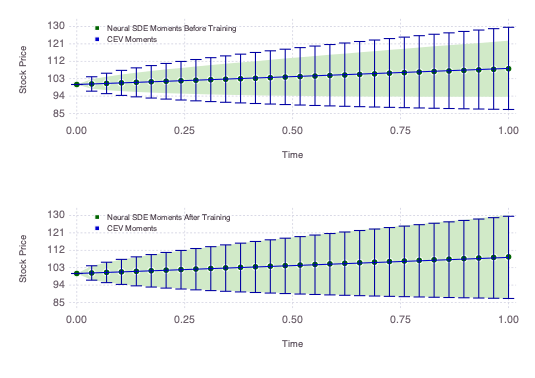

In [293]:
# Plotting moments

layer1 = layer(x = tsteps , y = CEV_Means, ymin= CEV_Means-sqrt.(CEV_Vars), ymax= CEV_Means+sqrt.(CEV_Vars),Geom.errorbar , Geom.line,Theme(line_width = 0.8pt,default_color=colorant"#0000CD"))  
layer2 = layer(x = tsteps , y = m_before,ymin=m_before-sqrt.(v_before) , ymax= m_before+sqrt.(v_before), Geom.point, Geom.ribbon,Theme(line_width = 1pt,default_color=colorant"#006400"))
p1 = Gadfly.plot(layer1,layer2,Guide.ylabel("Stock Price"),Guide.yticks(ticks = [85    94   103   112   121   130]),Guide.xticks(ticks = [0.0 0.25 0.5 0.75 1.0]), Guide.xlabel("Time"),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.manual_color_key("", ["Neural SDE Moments Before Training","CEV Moments"],["#006400","#0000CD"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.square,Gadfly.Shape.square]),Coord.cartesian(xmin=0, xmax=1, ymin=85, ymax=130)) 

layer3 = layer(x = tsteps , y = CEV_Means, ymin= CEV_Means-sqrt.(CEV_Vars), ymax= CEV_Means+sqrt.(CEV_Vars),Geom.errorbar , Geom.line,Theme(line_width = 0.8pt,default_color=colorant"#0000CD"))  
layer4 = layer(x = tsteps , y = means,ymin=means - sqrt.(vars) , ymax= means + sqrt.(vars), Geom.point, Geom.ribbon,Theme(line_width = 1pt,default_color=colorant"#006400"))
p2 = Gadfly.plot(layer3,layer4,Guide.ylabel("Stock Price"),Guide.yticks(ticks = [85    94   103   112   121   130]),Guide.xticks(ticks = [0.0 0.25 0.5 0.75 1.0]), Guide.xlabel("Time"),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.manual_color_key("", ["Neural SDE Moments After Training","CEV Moments"],["#006400","#0000CD"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.square,Gadfly.Shape.square]),Coord.cartesian(xmin=0, xmax=1, ymin=85, ymax=130))


plt = vstack(p1,p2)
#draw(PDF("myplot2.pdf", 14cm, 10cm), plt)